# ppsim Python package

The `ppsim` package is used for simulating population protocols. The package and further example notebooks can be found on [Github](https://github.com/UC-Davis-molecular-computing/ppsim).

The core of the simulator uses a [batching algorithm](https://arxiv.org/abs/2005.03584) which gives significant asymptotic gains for protocols with relatively small reachable state sets. The package is designed to be run in a Python notebook, to concisely describe complex protocols, efficiently simulate their dynamics, and provide helpful visualization of the simulation.

## Installation

The package can be installed with `pip` via

In [ ]:
pip install ppsim

The most important part of the package is the `Simulation` class, which is responsible for parsing a protocol, performing the simulation, and giving data about the simulation.

In [5]:
from ppsim import Simulation

## First example protocol

A state can be any hashable Python object. The simplest way to describe a protocol is a dictionary mapping pairs of input states to pairs of output states.
For example, here is a description of the classic 3-state [approximate majority protocol](http://www.cs.yale.edu/homes/aspnes/papers/approximate-majority-journal.pdf). There are two initial states `A` and `B`, and the protocol converges with high probability to the majority state with the help of a third "undecided" state `U`.

In [2]:
a, b, u = 'A', 'B', 'U'
approximate_majority = {
    (a,b): (u,u),
    (a,u): (a,a),
    (b,u): (b,b)
}

To instantiate a `Simulation`, we must specify a protocol along with an initial condition, which is a dictionary mapping states to counts. Let's simulate approximate majority with in a population of one billion agents with a slight majority of `A` agents.

In [3]:
n = 10 ** 9
init_config = {a: 0.501 * n, b: 0.499 * n}
sim = Simulation(init_config, approximate_majority)

Now let's run this simulation for `10` units of parallel time (`10 * n` interactions). We will record the configuration every `0.1` units of time.

In [4]:
sim.run(10, 0.1)

 Time: 10.000


The `Simulation` class can display all these configurations in a `pandas` dataframe in the attribute `history`.

In [5]:
sim.history

,A,B,U
time (n interactions),,,
0.0,501000000,499000000,0
0.1,459457762,457439751,83102487
0.2,430276789,428217565,141505646
0.3,409027376,406898254,184074370
0.4,393162729,390949934,215887337
...,...,...,...
9.7,771074143,55357812,173568045
9.8,789103074,48973925,161923001
9.9,806667929,43076383,150255688


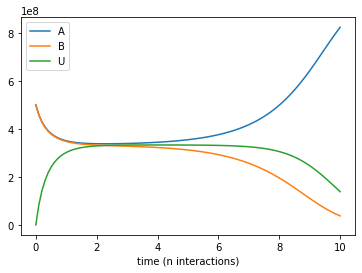

In [6]:
p = sim.history.plot()

Without specifying an end time, `run` will run the simulation until the configuration is silent (all interactions are null). In this case, that will be when the protocol reaches a silent majority consensus configuration.

 Time: 21.000


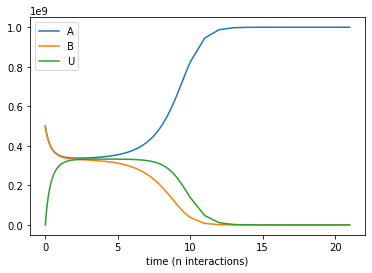

In [7]:
sim.run()
p = sim.history.plot()

Note that by default, `Simulation` assumes that input pair `(b,a)` will have the same transition as `(a,b)`, so order doesn't matter, with the default setting `transition_order = 'symmetric'`.
Thus we have the exact same protocol as if we had spent more time explicitly specifying

In [8]:
approximate_majority_symmetric = {
    (a,b): (u,u), (b,a): (u,u),
    (a,u): (a,a), (u,a): (a,a),
    (b,u): (b,b), (u,b): (b,b)
}

If we intentionally meant for these pairwise transitions to only happen in this specified order, we can declare that. We see in this case that it has the same behavior, but just runs twice as slow because now every interaction must happen in a specified order.

A, B  -->  U, U      with probability 0.5
A, U  -->  A, A      with probability 0.5
B, U  -->  B, B      with probability 0.5
 Time: 44.000


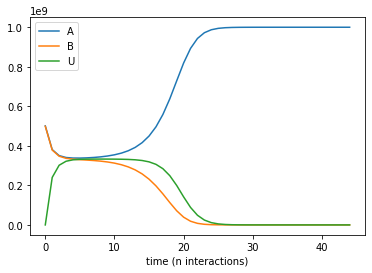

In [9]:
sim = Simulation(init_config, approximate_majority, transition_order='asymmetric')
print(sim.reactions)
sim.run()
p = sim.history.plot()

A key result about this protocol is it converges in expected O(log n) time, which surprisingly is very nontrivial to prove. We can use this package to very quickly gather some convincing data that the convergence really is O(log n) time, with the function `time_trials`.

In [10]:
from ppsim import time_trials
import numpy as np

ns = [int(n) for n in np.geomspace(10, 10 ** 8, 20)]
def initial_condition(n):
    return {'A': n // 2, 'B': n // 2}
df = time_trials(approximate_majority, ns, initial_condition, num_trials=100, max_wallclock_time = 30)
df

  0%|          | 0/20 [00:00<?, ?it/s]

,n,time
0,10,3.0
1,10,2.1
2,10,2.8
3,10,2.7
4,10,3.8
...,...,...
1492,42813323,23.8
1493,100000000,28.1
1494,100000000,25.2
1495,100000000,25.1


This dataframe collected time from up to 100 trials for each population size n across a many orders of magnitude, limited by the budget of 30 seconds of wallclock time that we gave it.
We can now use the `seaborn` library to get a convincing plot of the data.

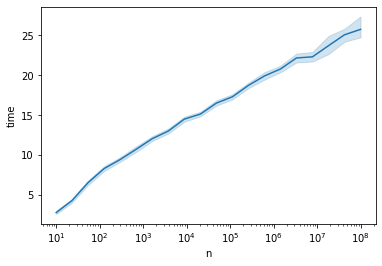

In [11]:
import seaborn as sns
lp = sns.lineplot(x='n', y='time', data=df)
lp.set_xscale('log')

## Larger state protocol

For more complicated protocols, it would be very tedious to use this dictionary format. Instead we can give an arbitrary Python function which takes a pair of states as input (along with possible other protocol parameters) and returns a pair of states as output (or if we wanted a randomized transition, it would output a dictionary which maps pairs of states to probabilities).

As a quick example, let's take a look at the discrete averaging dynamics, as analyzed [here](https://arxiv.org/abs/1808.05389) and [here](https://hal-cnrs.archives-ouvertes.fr/hal-02473856/file/main_JAP.pdf), which have been a key subroutine used in counting and majority protocols.

In [148]:
from math import ceil, floor

def discrete_averaging(a, b):
    avg = (a + b) / 2
    return floor(avg), ceil(avg)

n = 10 ** 6
sim = Simulation({0: n // 2, 50: n // 2}, discrete_averaging)

We did not need to explicitly describe the state set. Upon initialization, `Simulation` used breadth first search to find all states reachable from the initial configuration.

In [149]:
print(sim.state_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


This enumeration will call the function `rule` we give it O(q^2) times, where q is the number of reachable states. This preprocessing step also builds an internal representation of the transition function, so it will not need to continue calling `rule`. Thus we don't need to worry too much about our code for `rule` being efficient.

Rather than the dictionary format used to input the configuration, internally `Simulation` represents the configuration as an array of counts, where the ordering of the indices is given by `state_list`.

In [150]:
sim.config_dict

{0: 500000, 50: 500000}

In [151]:
sim.config_array

array([500000,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0, 500000], dtype=int64)

A key result about these discrete averaging dynamics is that they converge in O(log n) time to at most 3 consecutive values. It could take longer to reach the ultimate silent configuration with only 2 consecutive values, so if we wanted to check for the faster convergence condition, we could use a function that checks for the condition. This function takes a configuration dictionary (mapping states to counts) as input and returns `True` if the convergence criterion has been met.

In [152]:
def three_consecutive_values(config):
    states = config.keys()
    return max(states) - min(states) <= 2

Now we can run until this condition is met (or also use `time_trials` as above to generate statistics about this convergence time).

In [153]:
sim.run(three_consecutive_values, 0.1)
sim.history

 Time: 14.800


,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
time (n interactions),,,,,,,,,,,,,,,,,,,,,
0.0,500000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,500000
0.1,450215,1,1,20,3,1,391,134,2,8,...,9,0,125,395,0,2,16,0,0,450243
0.2,401257,11,11,229,30,14,2125,694,18,199,...,188,26,684,2165,11,27,176,10,7,401337
0.3,354726,46,61,715,146,70,4818,1643,114,721,...,753,134,1730,5086,75,122,720,53,33,354312
0.4,310248,106,145,1572,360,251,8297,2953,340,1720,...,1708,399,2926,8523,233,327,1653,161,116,309999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14.4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14.5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14.6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


With a much larger number of states, the `history` dataframe is more unwieldly, so trying to directly call `history.plot()` would be very messy and not very useful. Instead, we will define a function that makes a barplot, using the data in a single row of `sim.history` to visualize the distribution at that recorded time step.

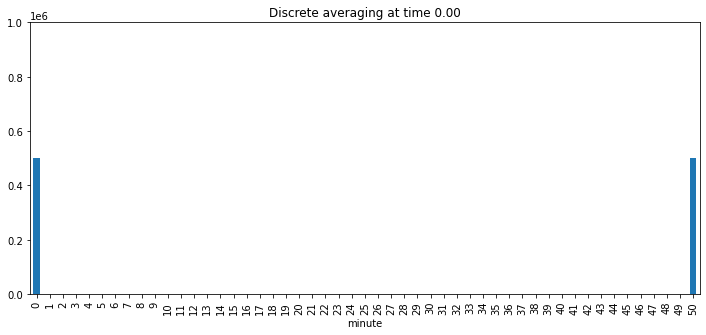

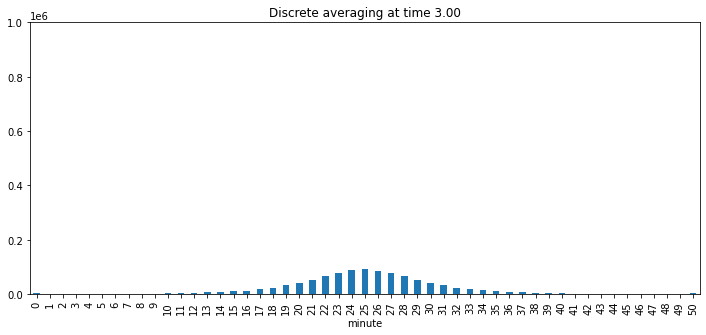

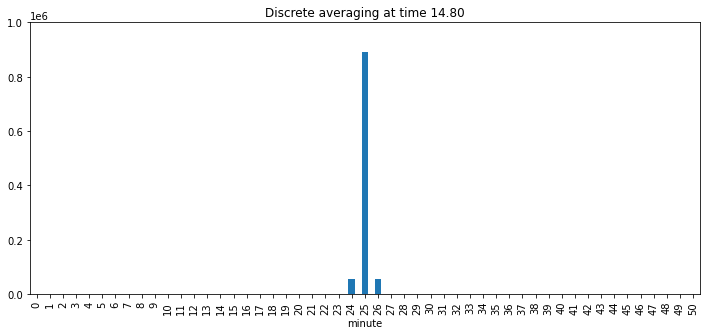

In [154]:
from matplotlib import pyplot as plt
def plot_row(row):
    fig, ax = plt.subplots(figsize=(12,5))
    sim.history.iloc[row].plot(ax=ax, kind='bar', 
                              title=f'Discrete averaging at time {sim.history.index[row]:.2f}', 
                              xlabel='minute',
                              ylim=(0,n))
plot_row(0)
plot_row(30)
plot_row(-1)

The `ipywidgets` library gives a quick way to make a slider that lets us visualize the evolution of this distribution:

In [ ]:
import ipywidgets as widgets
bar = widgets.interact(plot_row, row = widgets.IntSlider(
    min=0, max=len(sim.history)-1, step=1, value=0, layout = widgets.Layout(width='100%')))

It is recommended to use an interactive matplotlib backend, such as `ipympl`, which can be installed with `pip install ipympl` and then activated with the cell magic `%matplotlib widget`. The recommended environment to use for these notebooks is [Jupyter Lab](https://jupyterlab.readthedocs.io/en/stable/). Unfortunately, these interactive backends are not supported with [Google Colab](https://colab.research.google.com/), so there does not seem to be an easy way to have access to interactive backends with something that can be run only in a browser without local installation.

The code with the slider above was designed to work in the non-interactive backend. The following cell shows how to accomplish the same thing with an interactive backend:

In [157]:
# The following example uses the ipympl backend. It creates one figure and axis once and then modifies the axis directly with plot_row.
# If ipympl is installed, then uncommenting and running the following code will produce a slider that changes one single interactive figure object.

# %matplotlib widget
# def plot_row(row):
#     ax.clear()
#     sim.history.iloc[row].plot(ax=ax, kind='bar', 
#                               title=f'Discrete averaging at time {sim.history.index[row]:.2f}', 
#                               xlabel='minute',
#                               ylim=(0,n))
#     fig.canvas.draw()
    
# fig, ax = plt.subplots()
# bar = widgets.interact(plot_row, row = widgets.IntSlider(
#     min=0, max=len(sim.history)-1, step=1, value=0, layout = widgets.Layout(width='100%')))

Because the population average was exactly 25, the ultimate silent configuration will have every agent in state 50, but it will take a a very long time to reach, as we must wait for pairwise interactions between dwindling counts of states 24 and 26. We can check that this reaction is now the only possible non-null interaction.

In [156]:
print(sim.enabled_reactions)

24, 26  -->  25, 25


As a result, the probability of a non-null interaction will grow very small, upon which the simulator will switch to the Gillespie algorithm. This allows it to relatively quickly run all the way until silence, which we can confirm takes a very long amount of parallel time.

In [158]:
# Setting history_interval to be a function of time t that shrinks, to not record too many configurations over a long time scale
sim.run(history_interval=lambda t: 10 ** len(str(int(t))) / 100)

 Time: 578983.800


To better visualize small count states, we add an option to change `yscale` from `linear` to `symlog`.

In [ ]:
def plot_row(row, yscale):
    fig, ax = plt.subplots(figsize=(12,5))
    sim.history.iloc[row].plot(ax=ax, kind='bar', 
                              title=f'Discrete averaging at time {sim.history.index[row]:.2f}', 
                              xlabel='minute',
                              ylim=(0,n))
    ax.set_yscale(yscale)
    
bar = widgets.interact(plot_row, 
                       row = widgets.IntSlider(min=0, max=len(sim.history)-1, step=1, value=0, layout = widgets.Layout(width='100%')),
                      yscale = ['linear','symlog'])

## Protocol with Multiple Fields

For more complicated protocol, it is helpful to have the states be more complicated Python objects. A recommended method is to define an Agent [dataclass](https://docs.python.org/3/library/dataclasses.html) that includes various fields.

As a concrete example, we will use the protocol from [Simple and Efficient Leader Election](https://drops.dagstuhl.de/opus/volltexte/2018/8302/pdf/OASIcs-SOSA-2018-9.pdf). We start by translating the explicit description of an agents state into our Agent class.

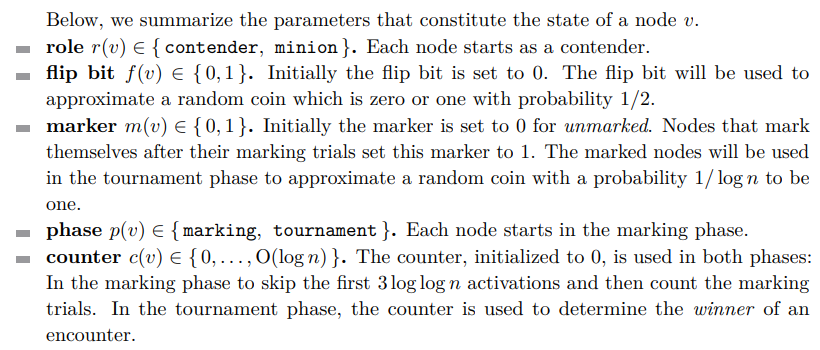

In [160]:
import dataclasses
from dataclasses import dataclass

# The parameter unsafe_hash=True makes the state hashable, as required, but still lets the transition code change the field values
# Note that ppsim will by default make safe copies of the agent states before applying the rule,
#  so it is safe to mutate the fields of an agent in the transition rule

@dataclass(unsafe_hash=True)
class Agent:
    role: str = 'contender'
    flip_bit: int = 0
    marker: int = 0
    phase: str = 'marking'
    counter: int = 0

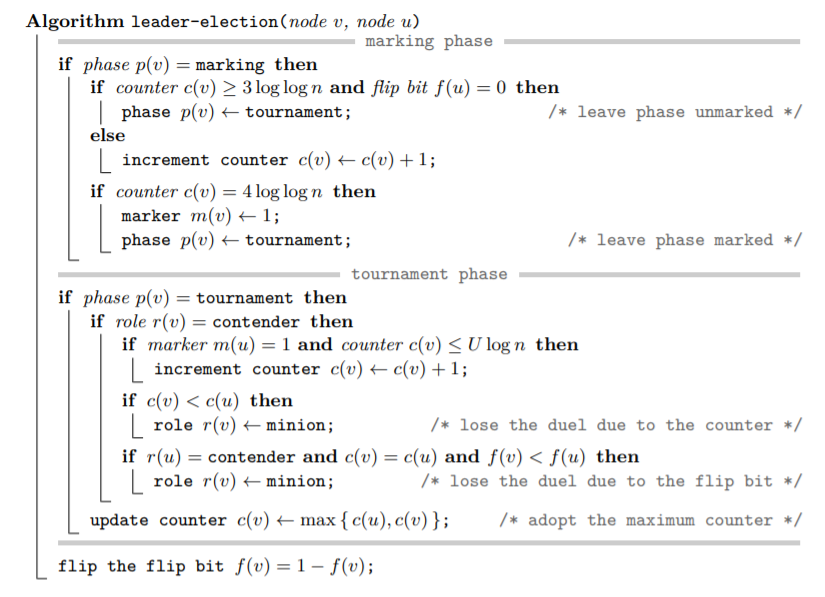

In [161]:
def leader_election(v: Agent, u: Agent, loglogn: int, Ulogn: int):
    # marking phase
    if v.phase == 'marking':
        if v.counter >= 3 * loglogn and u.flip_bit == 0:
            v.phase = 'tournament'
        else:
            v.counter += 1
        if v.counter == 4 * loglogn:
            v.marker = 1
            v.phase = 'tournament'
    
    if v.phase == 'tournament':
        if v.role == 'contender':
            if u.marker and v.counter <= Ulogn:
                v.counter += 1
            if v.counter < u.counter:
                v.role = 'minion'
            if u.role == 'contender' and v.counter == u.counter and v.flip_bit < u.flip_bit:
                v.role = 'minion'
        v.counter = max(v.counter, u.counter)
        
    v.flip_bit = 1 - v.flip_bit
    
    return v

The pseudocode was described in the following way:

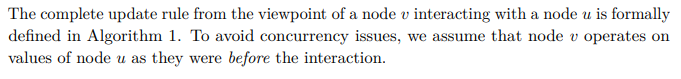

We can implement this assumption by having our transition rule call the the `leader_election` function twice:

In [162]:
def transition(v: Agent, u: Agent, loglogn: int, Ulogn: int):
    return leader_election(v, dataclasses.replace(u), loglogn, Ulogn), leader_election(u, dataclasses.replace(v), loglogn, Ulogn)

We can first check instantiate the protocol for various population sizes, to confirm that the number of reachable states is scaling like we expect.

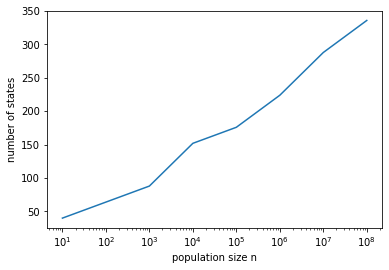

In [163]:
import numpy as np
ns = [int(n) for n in np.geomspace(10, 10 ** 8, 8)]
states = []
for n in ns:
    sim = Simulation({Agent(): n}, transition, loglogn=int(np.log2(np.log2(n))), Ulogn= u * int(np.log2(n)))
    states.append(len(sim.state_list))
plt.plot(ns, states)
plt.xscale('log')
plt.xlabel('population size n')
plt.ylabel('number of states')
plt.show()

Now we will simulate the rule for a population of one billion agents, and run it until it gets to one leader.

In [164]:
n = 10 ** 9
sim = Simulation({Agent(): n}, transition, loglogn=int(np.log2(np.log2(n))), Ulogn= u * int(np.log2(n)))
def one_leader(config):
    leader_states = [state for state in config.keys() if state.role == 'contender']
    return len(leader_states) == 1 and config[leader_states[0]] == 1
sim.run(one_leader)

 Time: 67.253


Because there are hundreds of states, the full history dataframe is more complicated.

In [165]:
sim.history

role                    contender                                              \
flip_bit                        0                                               
marker                          0                                               
phase                     marking                                               
counter                        0          2          4          6          8    
time (n interactions)                                                           
0.000000               1000000000          0          0          0          0   
1.000000                135336837  270661696   90227329   12028156     859080   
2.000000                 18312018  146524448  195383216  104189030   29773512   
3.000000                  2478690   44626126  133867363  160631023  103263148   
4.000000                   335736   10736616   57260444  122138990  139568370   
...                           ...        ...        ...        ...        ...   
64.000000                       0          0          0          0          0   
65.000000                       0          0          0          0          0   
66.000000                       0          0          0          0          0   
67.000000                       0          0          0          0          0   
67.252549                       0          0          0          0          0   

role                                                                    ...  \
flip_bit                                                                ...   
marker                                                                  ...   
phase                                              tournament           ...   
counter                      10        12       14         12       13  ...   
time (n interactions)                                                   ...   
0.000000                      0         0        0          0        0  ...   
1.000000                  38162      1148        6         10        8  ...   
2.000000                5298122    641440    13908      30153    14976  ...   
3.000000               41305948  11269344   556907    1287669   649759  ...   
4.000000               99261227  48123925  4232398   10487317  5527630  ...   
...                         ...       ...      ...        ...      ...  ...   
64.000000                     0         0        0          0        0  ...   
65.000000                     0         0        0          0        0  ...   
66.000000                     0         0        0          0        0  ...   
67.000000                     0         0        0          0        0  ...   
67.252549                     0         0        0          0        0  ...   

role                      minion                             
flip_bit                       1                             
marker                         1                             
phase                 tournament                             
counter                       50 51 52 53 54 55 56 57 58 59  
time (n interactions)                                        
0.000000                       0  0  0  0  0  0  0  0  0  0  
1.000000                       0  0  0  0  0  0  0  0  0  0  
2.000000                       0  0  0  0  0  0  0  0  0  0  
3.000000                       0  0  0  0  0  0  0  0  0  0  
4.000000                       0  0  0  0  0  0  0  0  0  0  
...                          ... .. .. .. .. .. .. .. .. ..  
64.000000                      0  0  0  0  0  0  0  0  0  0  
65.000000                      0  0  0  0  0  0  0  0  0  0  
66.000000                      0  0  0  0  0  0  0  0  0  0  
67.000000                      0  0  0  0  0  0  0  0  0  0  
67.252549                      0  0  0  0  0  0  0  0  0  0  

[69 rows x 384 columns]

Because we defined a state as a dataclass `Agent`, which had fields, the columns of the `history` dataframe are a pandas [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.MultiIndex.html).

In [166]:
sim.history.columns

MultiIndex([('contender', 0, 0,    'marking',  0),
            ('contender', 0, 0,    'marking',  2),
            ('contender', 0, 0,    'marking',  4),
            ('contender', 0, 0,    'marking',  6),
            ('contender', 0, 0,    'marking',  8),
            ('contender', 0, 0,    'marking', 10),
            ('contender', 0, 0,    'marking', 12),
            ('contender', 0, 0,    'marking', 14),
            ('contender', 0, 0, 'tournament', 12),
            ('contender', 0, 0, 'tournament', 13),
            ...
            (   'minion', 1, 1, 'tournament', 50),
            (   'minion', 1, 1, 'tournament', 51),
            (   'minion', 1, 1, 'tournament', 52),
            (   'minion', 1, 1, 'tournament', 53),
            (   'minion', 1, 1, 'tournament', 54),
            (   'minion', 1, 1, 'tournament', 55),
            (   'minion', 1, 1, 'tournament', 56),
            (   'minion', 1, 1, 'tournament', 57),
            (   'minion', 1, 1, 'tournament', 58),
            (  

We can use the pandas [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) function to conveniently look at the values of just one field. For a field whose name is the string `field`, then calling `sim.history.groupby(field, axis=1).sum()` gives the counts of values of just a single state. If we have a set of fields `field1, field2, ...` then calling `sim.history.groupby([field1, field2, ...], axis=1).sum()` will give the counts of values of just those fields.

In [167]:
sim.history.groupby('role', axis=1).sum()

role,contender,minion
time (n interactions),,
0.000000,1000000000,0
1.000000,1000000000,0
2.000000,999999972,28
3.000000,999969579,30421
4.000000,998042414,1957586
...,...,...
64.000000,2,999999998
65.000000,2,999999998
66.000000,2,999999998


This lets us quickly plot the counts of leaders, to see how it decreases down to one leader, and the count in each phase, to see when the agents transition from the marking phase to the tournament phase.

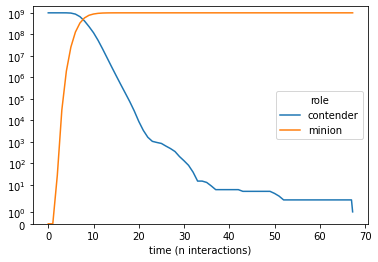

In [168]:
sim.history.groupby('role', axis=1).sum().plot()
plt.yscale('symlog')
plt.ylim(0, 2*n)
plt.show()

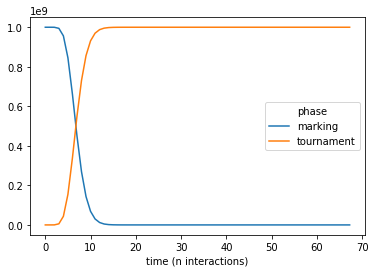

In [169]:
sim.history.groupby('phase', axis=1).sum().plot()
plt.show()

For this protocol, a good understanding of why it is working comes from looking at the product of `role` and `counter` values. The way the protocol works is that contenders increase their counter values, which spread by epidemic among all minions, to eliminate other contenders with smaller counter values.

We will again try to visualize a single row of the dataframe that projects onto just the `role` and `counter` values. Calling `df.iloc[index]` gives us a [Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html)

In [170]:
df = sim.history.groupby(['counter','role'], axis=1).sum()
df.iloc[10]

counter  role     
0        contender        2
1        contender       48
2        contender      441
3        contender     2876
4        contender    13600
                      ...  
57       minion           0
58       contender        0
         minion           0
59       contender        0
         minion           0
Name: 10.0, Length: 108, dtype: int64

Then calling `unstack()` on the series will give pull off the first field, and give us a dataframe that can immediately plotted as a multibar plot.

In [171]:
df.iloc[10].unstack()

role,contender,minion
counter,,
0,2.0,NaN
1,48.0,NaN
2,441.0,NaN
3,2876.0,NaN
4,13600.0,NaN
5,55257.0,NaN
6,183276.0,NaN
7,523542.0,NaN
8,1305762.0,NaN


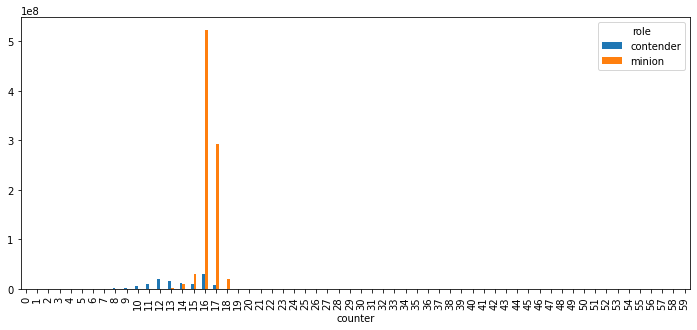

In [172]:
df.iloc[10].unstack().plot(kind='bar', figsize=(12,5))
plt.show()

Now we can define a function that creates one of these plots at an arbitrary row, to get a similar slider that lets us quickly visualize the evolution of the distributions.

In [ ]:
def plot_row(row, yscale):
    fig, ax = plt.subplots(figsize=(12,5))
    df.iloc[row].unstack().plot(ax=ax, kind='bar', 
                              ylim=(0,n))
    ax.set_yscale(yscale)
bar = widgets.interact(plot_row, 
                       row = widgets.IntSlider(min=0, max=len(sim.history)-1, step=1, value=0, layout = widgets.Layout(width='100%')),
                      yscale = ['linear','symlog'])

## Simulating Chemical Reaction Networks (CRNs)

`ppsim` is able to simulate any Chemical Reaction Network that has only bimolecular (2-input, 2-output) and unimolecular (1-input, 1-output) reactions. There is a special syntax used to specify CRNs, such as

$$
A + B \mathop{\rightleftharpoons}\limits
^{0.5}_4 2C, 
\quad\quad
C \mathop{\rightarrow}\limits^5 D
$$


In [16]:
from ppsim import species

a,b,c,d = species('A B C D')
crn = [(a+b | 2*c).k(0.5).r(4), (c >> d).k(5)]

First we define `species` objects `a,b,c,d`. We then create `crn`, a list of `reaction` objects, which are created by composing these species. Using the `>>` operator creates an irreversible (one-way) reaction, while using the `|` operator creates a reversible (two-way) reaction. A rate constant can be added with the method `reaction.k(...)`, and the reverse rate constant is added with the method `reaction.r(...)`. If not specified, rate constants are assumed to be 1.

 Time: 37.000


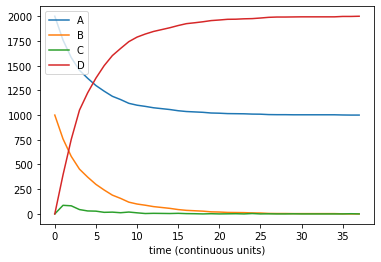

In [17]:
sim = Simulation({a: 2000, b:1000}, crn)
sim.run()
p = sim.history.plot()

CRNs are normally modelled by Gillespie kinetics, which gives a continuous time Markov process. The unimolecular reaction $C \mathop{\rightarrow}\limits^5 D$ happens as a Poisson process with rate 5. The forward bimolecular reaction $A+B \mathop{\rightarrow}\limits^{0.5} 2C$ happens as a Poisson process with rate $0.5 \cdot \frac{\# A \cdot \#B}{v}$, and the reverse bimolecular reaction happens as a Poisson process with rate $4 \cdot \frac{\#B (\#B - 1)}{2v}$, where $v$ is the volume parameter.

When creating a `Simulation` with a list of `reaction` objects, `ppsim` will by default use this continuous time model.
By default, `ppsim` sets the volume $v$ to be the population size $n$, which makes the time units independent of population size. In some models, this volume parameter is instead baked directly into the numerical rate constant. In this case, the volume should be set manually in the Simulation constructor, with `Simulation(..., volume = 1)`. In addition, if these numerical rate constants are specified in specific time units (such as per second), this can be specified with `Simulation(..., time_units='seconds')`, and then all times will appear with appropriate units.

For more details about the CRN model and how it is faithfully represented as a continuous time population protocol, see [this paper](https://arxiv.org/abs/2105.04702).

## More examples
See https://github.com/UC-Davis-molecular-computing/population-protocols-python-package/tree/main/examples/